In [1]:
!python -m venv venv_ia_tickets_v2

In [1]:
pip install -r requirements.txt

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/c8/7b/bdcb1ed8fccb63d04bdb7635161d0ec26596d92c9d7a6cce964e7876b6c1/pandas-2.3.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/f4/5a/ba91b8c57aa37dbd80d5ff958576a9a8c14317b04b671ae7f0d09b00993a/scikit_learn-1.7.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/29/22/e3ff2dfafe862a91733dfa0aecdb4794aa1d9a18e09a14e118bde0cbc2db/xgboost-3.0.2-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/d0/30/dc54f88dd4a2b5dc8a0279bdd7270e735851848b762aeb1c1184ed1f6b14/tqdm-4.67.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------------------- 57.7/57.7 kB 3.2 MB/s eta 0:00:00
     --------------------


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from datetime import timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from xgboost import XGBRegressor
# from tqdm import tqdm
import unicodedata
import subprocess
import importlib
import swifter 
import joblib
import spacy
import nltk
import re
import os

h:\IA_prédiction\venv_ia_tickets_v2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def safe_spacy_load(model_name):
    """Télécharge et charge un modèle spaCy s'il n'est pas présent."""
    try:
        return spacy.load(model_name)
    except OSError:
        print(f"📦 Téléchargement automatique du modèle spaCy : {model_name}")
        subprocess.run(["python", "-m", "spacy", "download", model_name], check=True)
        return spacy.load(model_name)

In [ ]:

# Téléchargement des ressources si nécessaire
try:
    stop_fr = set(stopwords.words('french'))
    stop_en = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_fr = set(stopwords.words('french'))
    stop_en = set(stopwords.words('english'))

# Initialisation des correcteurs
spell_fr = SpellChecker(language='fr')
spell_en = SpellChecker(language='en')

# Chargement sécurisé des modèles français et anglais
nlp_fr = safe_spacy_load("fr_core_news_sm")
nlp_en = safe_spacy_load("en_core_web_sm")

In [76]:
# Lire les fichiers réels
zh12_path = "export_ZH12.xlsx"
jira_path = "export_JIRA.csv"

# Chargement des fichiers
zh12 = pd.read_excel(zh12_path)
jira = pd.read_csv(jira_path, encoding="latin1")

In [83]:
# Nettoyage dates
zh12["Date"] = pd.to_datetime(zh12["Date"], dayfirst=True, errors='coerce')
zh12 = zh12.dropna(subset=["Date"])
zh12 = zh12.dropna(subset=["Jira"])

In [97]:
jira["Date de création"] = pd.to_datetime(jira["Date de creation"], dayfirst=True, errors='coerce')
jira = jira.dropna(subset=["Date de creation"])
jira = jira.dropna(subset=["Date de cloture"])

In [38]:
zh12

In [56]:
jira

In [85]:

# Création d'un champ "Type_Étendu" = Type + Nom du Client
jira["Type_Étendu"] = jira["Vorgangsart Name"].astype(str) + "__" + jira["Nom du Client"].astype(str)

# Agrégation : total d'heures par (Matricule, Jira)
aggr = zh12.groupby(["Matricule", "Jira"], as_index=False).agg({
    "Durée tâche (heures)": "sum",
    "Code Service": "first"
})

# Fusion avec JIRA
fusion = aggr.merge(jira, on="Jira", how="left")
fusion.rename(columns={"Durée tâche (heures)": "Duree", "Date de création": "Date"}, inplace=True)

# Historique glissant 1 an basé sur Type_Étendu
history = []
for idx, row in fusion.iterrows():
    matricule = row["Matricule"]
    typ = row["Type_Étendu"]
    date = row["Date"]
    if pd.isna(matricule) or pd.isna(typ) or pd.isna(date):
        history.append(None)
        continue

    date_min = date - timedelta(days=365)
    past_tasks = fusion[
        (fusion["Matricule"] == matricule) &
        (fusion["Type_Étendu"] == typ) &
        (fusion["Date"] < date) &
        (fusion["Date"] >= date_min)
    ]
    mean_val = past_tasks["Duree"].mean() if not past_tasks.empty else None
    history.append(mean_val)

fusion["Historique_1an"] = history
fusion["Historique_1an"] = fusion["Historique_1an"].fillna(0)

# Suppression des lignes incomplètes (NaN)
fusion.dropna(subset=["Matricule", "Jira", "Duree", "Type_Étendu", "Date"], inplace=True)

# Affichage final (échantillon)
print(fusion[["Matricule", "Jira", "Duree", "Type_Étendu", "Date", "Historique_1an"]].head())


In [93]:
# Caches pour optimiser
correction_cache = {}
lemmatisation_cache = {}

# Liste blanche de mots techniques/acronymes à préserver
whitelist = {"idoc", "sap", "vpn", "teams", "jira", "sql", "pdf", "ssl"}

def clean_encoding(text):
    try:
        text = text.encode('latin1').decode('utf-8')
    except:
        pass
    text = text.replace("�", "")
    return unicodedata.normalize('NFKC', text)

def corriger_orthographe(mot):
    if mot in correction_cache:
        return correction_cache[mot]
    corr = spell_fr.correction(mot)
    if corr is None or corr == mot:
        corr = spell_en.correction(mot)
    correction_cache[mot] = corr if corr else mot
    return correction_cache[mot]

def lemmatiser_mot(mot):
    if mot in lemmatisation_cache:
        return lemmatisation_cache[mot]
    doc_fr = nlp_fr(mot)
    if doc_fr and doc_fr[0].lemma_ != mot:
        lemmatisation_cache[mot] = doc_fr[0].lemma_
        return lemmatisation_cache[mot]
    doc_en = nlp_en(mot)
    lemmatisation_cache[mot] = doc_en[0].lemma_ if doc_en else mot
    return lemmatisation_cache[mot]

def preprocess_libelle(text):
    if not isinstance(text, str):
        return ""
    # Nettoyage de l'encodage et de la ponctuation
    text = clean_encoding(text)
    text = re.sub(r"[^\w\s]", " ", text)
    mots = text.split()

    mots_cles = []
    for m in mots:
        m_lower = m.lower()
        # Option 1 : ignorer les majuscules (acronymes)
        if m.isupper() and len(m) > 2:
            mots_cles.append(m_lower)
            continue
        # Option 2 : ignorer les mots en whitelist
        if m_lower in whitelist:
            mots_cles.append(m)
            continue
        # Option 3 : stop words + correction/lemmatisation
        if m not in stop_fr and m not in stop_en and len(m) > 2:
            mot_corr = corriger_orthographe(m_lower)
            mot_lem = lemmatiser_mot(mot_corr)
            mots_cles.append(mot_lem)
    return " ".join(mots_cles)

# Application avec swifter ou tqdm si swifter indisponible
# tqdm.pandas(desc="Nettoyage NLP Jira")
swifter.set_defaults(pbar=True, progress_bar=True, allow_dask_on_strings=True, error_score="raise")
fusion["Libelle Jira"] = fusion["Libelle Jira"].fillna("")
# fusion["Libelle Jira clean"] = fusion["Libelle Jira"].progress_apply(preprocess_libelle)
fusion["Libelle Jira clean"] = fusion["Libelle Jira"].swifter.apply(preprocess_libelle)


In [2]:
fusion.to_csv("fusion_libelle_clean.csv", index=False, encoding="utf-8", sep=";")

NameError: name 'fusion' is not defined

In [6]:
fusion = pd.read_csv("fusion_libelle_clean.csv", sep=";", encoding="utf-8")
fusion = fusion.dropna(subset=["Date de cloture"])
fusion = fusion[fusion["Resolution"] == "Done"].copy()
fusion["nb_jira"] = fusion["Jira"].str.extract(r"-(\d+)", expand=False).astype(float)


In [4]:
fusion

,Matricule,Jira,Duree,Code Service,Jira ticket ID,Jira parent ID,Libelle Jira,Vorgangsart Name,Resolution,RACF ID,...,Effort estimation,Type (internal/external),Auteur modification,Date de modification.1,Heure modification,Date,Type_Étendu,Historique_1an,Libelle Jira clean,nb_jira
0,7000100,ULIS-14638,1.00,SCM-IT-FR-CP,1334844.0,NaN,NUXE : Accï¿½s JP6-343 (TETA006),Service Request,Done,NaN,...,0.0,NaN,ESTIV01,07.07.2025,110227.0,2023-01-04,Service Request__CROSS SAP FR,0.000000,nuxe accès jp6 343 teta006,14638
1,719,SCMF-2393,2.00,KU,2623055.0,763763.0,[BMS] Prio_2 : Dï¿½comissionnement dï¿½clenchï...,Change,Done,VONG011,...,0.0,Internal CR,NaN,NaN,NaN,2023-07-03,Change__BMS,0.000000,bms prion commissionnement déclenché pic pack ...,2393
2,719,SCMF-2668,3.00,KU,3506017.0,763763.0,Roche: Changement dï¿½termination ZARM_routing...,Change,Done,VONG011,...,0.0,Internal CR,NaN,NaN,NaN,2024-01-24,Change__ROCHE,0.000000,roche changement détermination zarm_route lfdn...,2668
3,719,ULIS-25615,1.20,KU,7010106.0,NaN,IDOC ENTRANT,Incident,Done,GARC710,...,0.0,NaN,ESTIV01,07.07.2025,124004.0,2024-09-24,Incident__FME,0.000000,idoc entrant,25615
4,719,ULIS-25617,1.12,KU,7010336.0,NaN,Demande de Licence SAP,Service Request,Done,GARC710,...,0.0,NaN,ESTIV01,07.07.2025,124004.0,2024-09-24,Service Request__CROSS SAP FR,0.000000,demand licence sap,25617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15705,9022163,ULIS-33104,1.57,KU,8062860.0,NaN,VALIDATION SORTIE DE MARCHANDISES,Incident,Done,MERC092,...,0.0,NaN,ESTIV01,07.07.2025,133002.0,2025-06-24,Incident__3M,1.305568,validation sortie marchandises,33104
15706,9022163,ULIS-33130,1.18,KU,8070246.0,NaN,Retour - Process dï¿½commissionnement ZPHA_VER...,Service Request,Done,MERC092,...,0.0,NaN,ESTIV01,07.07.2025,133002.0,2025-06-25,Service Request__CROSS HC JP6,1.000000,detour promet commissionnement zpha_verificati...,33130
15707,9022163,ULIS-33163,1.52,KU,8076828.0,NaN,Ajout email aux destinataires du rapport : Abb...,Service Request,Done,MERC092,...,0.0,NaN,ESTIV01,07.07.2025,133002.0,2025-06-26,Service Request__ABBOTT B2B,2.195000,about émail destinataire rapport abbott b2b we...,33163
15708,9022163,ULIS-33310,2.00,KU,8086682.0,NaN,gros volume rebus sur le convoyeur,Incident,Done,MERC092,...,0.0,NaN,MERC092,02.07.2025,113213.0,2025-06-30,Incident__ABBOTT B2B,2.064792,gro volume refu conveyer,33310


In [7]:
# Version percentile 99%
seuil_max = fusion["Duree"].quantile(0.99)
fusion = fusion[fusion["Duree"] <= seuil_max].copy()
fusion["Libelle Jira clean"] = fusion["Libelle Jira clean"].fillna("")


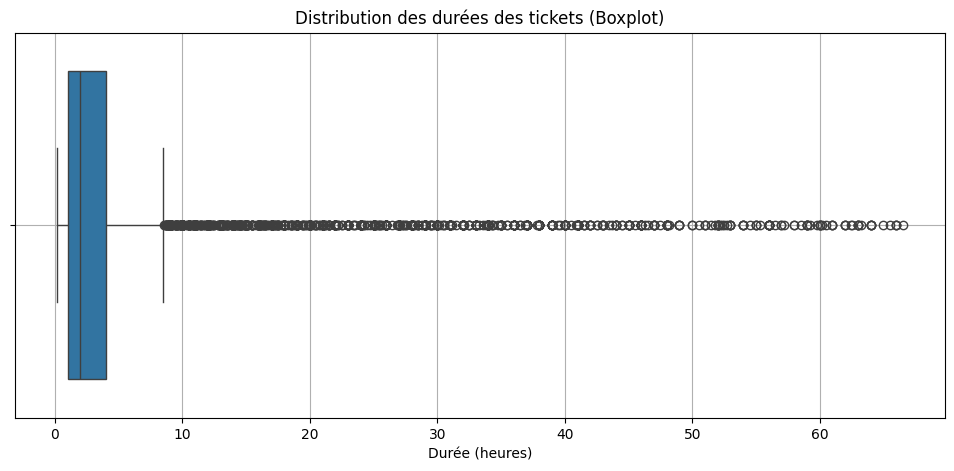

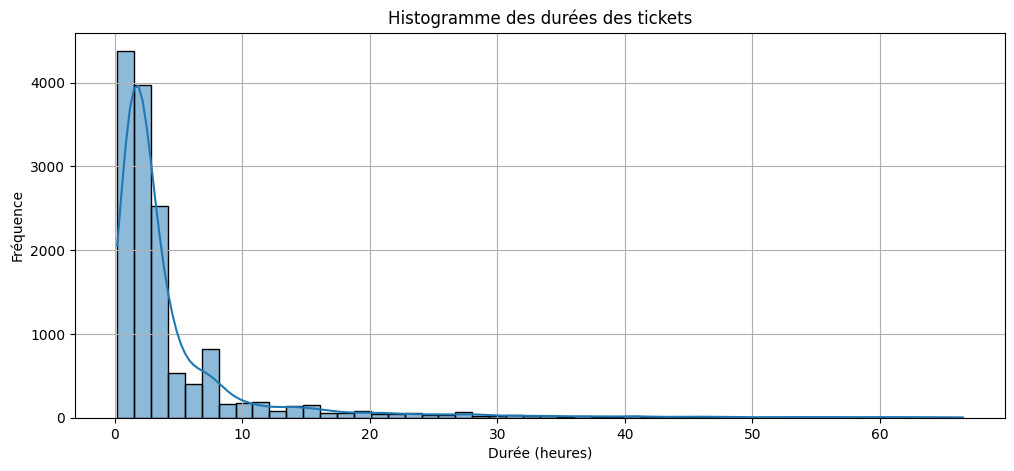

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- Analyse des valeurs extrêmes de la durée -----------

# Boxplot : détecte les outliers visuellement
plt.figure(figsize=(12, 5))
sns.boxplot(x=fusion["Duree"])
plt.title("Distribution des durées des tickets (Boxplot)")
plt.xlabel("Durée (heures)")
plt.grid(True)
plt.show()

# Histogramme avec courbe de densité
plt.figure(figsize=(12, 5))
sns.histplot(fusion["Duree"], bins=50, kde=True)
plt.title("Histogramme des durées des tickets")
plt.xlabel("Durée (heures)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()


In [9]:
# -------------------------
# Étape 3 : Vectorisation NLP du libellé Jira (TF-IDF)
# -------------------------

# Vectorisation TF-IDF sur les mots-clés nettoyés
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(fusion["Libelle Jira clean"])

# Création du DataFrame des vecteurs
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{w}" for w in tfidf.get_feature_names_out()])
fusion = pd.concat([fusion.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)


In [28]:
# Vérifie les lignes avec Priorité vide ou manquante
missing_priorite = fusion[fusion["Code Service"].isna() | (fusion["Code Service"].astype(str).str.strip() == "")]

# Affiche le nombre et les premières lignes
print(f"🔍 Nombre de lignes sans 'Code Service' : {len(missing_priorite)}")
print(missing_priorite[["Jira", "Code Service"]].head())


🔍 Nombre de lignes sans 'Code Service' : 0
Empty DataFrame
Columns: [Jira, Code Service]
Index: []


In [29]:
# -------------------------
# Étape 4 : Entraînement XGBoost (sans NLP)
# -------------------------
from sklearn.preprocessing import OrdinalEncoder

# Encodage persistant
cat_features = ["Matricule", "Project Key", "Type_Étendu","Code Service"]
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
x_cat = enc.fit_transform(fusion[cat_features])
x_encoded = pd.DataFrame(x_cat, columns=cat_features)

# Construction du DataFrame de features
x_base = x_encoded.copy()
x_base["nb_jira"] = fusion["nb_jira"]
x_base["Date"] = pd.to_numeric(pd.to_datetime(fusion["Date"]))
x_base["Historique_1an"] = fusion["Historique_1an"]
x_base["Duree"] = fusion["Duree"]

y = x_base.pop("Duree")

x_train, x_test, y_train, y_test = train_test_split(x_base, y, test_size=0.2, random_state=42)
model_base = XGBRegressor(n_estimators=100, random_state=42)
model_base.fit(x_train, y_train, verbose=True)

# Sauvegarde de l'encodeur
joblib.dump(enc, "models/xgb_encoder_base.pkl")

pred_base = model_base.predict(x_test)
print("MAE sans NLP:", mean_absolute_error(y_test, pred_base))

# Calcul des erreurs
errors = abs(y_test - pred_base)
mae = mean_absolute_error(y_test, pred_base)
min_err = errors.min()
max_err = errors.max()

# Affichage
print(f"MAE sans NLP : {mae:.4f} heures")
print(f"Erreur minimale : {min_err:.4f} heures")
print(f"Erreur maximale : {max_err:.4f} heures")

# Sauvegarde modèle sans NLP
os.makedirs("models", exist_ok=True)
joblib.dump(model_base, "models/xgb_model_base.pkl")

MAE sans NLP: 3.5931625140597543
MAE sans NLP : 3.5932 heures
Erreur minimale : 0.0001 heures
Erreur maximale : 56.9184 heures


['models/xgb_model_base.pkl']

In [32]:
# -------------------------
# Étape 5 : Entraînement XGBoost (avec NLP + variables catégorielles)
# -------------------------
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Encodage des colonnes catégorielles uniquement
cat_features_nlp = ["Matricule", "Project Key", "Type_Étendu"]
enc_nlp = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoded_cat = enc_nlp.fit_transform(fusion[cat_features_nlp])
encoded_df = pd.DataFrame(encoded_cat, columns=cat_features_nlp)

# Fusion des features catégorielles, historiques, nb_jira et TF-IDF
x_nlp = pd.concat([
    encoded_df.reset_index(drop=True),
    fusion[["nb_jira", "Historique_1an"]].reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

y_nlp = fusion["Duree"].copy()

# Séparation entraînement/test
x_train_nlp, x_test_nlp, y_train_nlp, y_test_nlp = train_test_split(x_nlp, y_nlp, test_size=0.2, random_state=42)

# Création du pipeline
pipeline_nlp = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(n_estimators=100, random_state=42, verbosity=1))
])

# Entraînement
pipeline_nlp.fit(x_train_nlp, y_train_nlp)

# Évaluation
pred_nlp = pipeline_nlp.predict(x_test_nlp)
errors = abs(y_test_nlp - pred_nlp)
mae = mean_absolute_error(y_test_nlp, pred_nlp)

print(f"MAE avec NLP : {mae:.4f} heures")
print(f"Erreur minimale : {errors.min():.4f} heures")
print(f"Erreur maximale : {errors.max():.4f} heures")

# -------------------------
# Top 10 erreurs les plus fortes (avec contexte)
# -------------------------
erreur_df = pd.DataFrame({
    "y_true": y_test_nlp,
    "y_pred": pred_nlp,
    "erreur_absolue": errors
}, index=y_test_nlp.index)

top_10_erreurs = erreur_df.sort_values(by="erreur_absolue", ascending=False).head(10)
top_10_erreurs = fusion.loc[top_10_erreurs.index][["Matricule", "Jira"]].join(top_10_erreurs)
print("\n🔍 Top 10 des plus grandes erreurs de prédiction :")
print(top_10_erreurs)

# Sauvegardes
joblib.dump(pipeline_nlp, "models/xgb_pipeline_nlp.pkl")
joblib.dump(enc_nlp, "models/xgb_encoder_nlp.pkl")

MAE avec NLP : 3.5679 heures
Erreur minimale : 0.0011 heures
Erreur maximale : 56.6368 heures

🔍 Top 10 des plus grandes erreurs de prédiction :
       Matricule        Jira  y_true     y_pred  erreur_absolue
12181    7000546  ULIS-20003   61.00   4.363236       56.636764
8985     7000182  ULIS-19386   64.00   7.409954       56.590046
8570     7000131  ULIS-15461   60.00   4.711266       55.288734
8913     7000182   SCMF-2442   62.48   8.963333       53.516667
8959     7000182  ULIS-15510   60.16   8.180240       51.979760
704      1901721   ULIS-6241   56.50   5.071413       51.428587
795      1902193   SCMF-1650   64.00  13.029356       50.970644
4800     6210728   SCMF-1944   66.00  15.486182       50.513818
92       1900483   SCMF-2148   62.50  12.251545       50.248455
862      1902193  ULIS-11545   54.00   5.071413       48.928587


['models/xgb_encoder_nlp.pkl']